In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src
from src.reload import reload_from_dir
import tensorflow as tf
import amber

Using TensorFlow backend.


kinn_sty = {
    "axes.titlesize": 18,
    "axes.labelsize": 20,
    "lines.linewidth": 1,
    "lines.markersize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "font.size": 18,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(kinn_sty)

In [3]:
def read_kinn_train_hist(hist_fps):
    dfs = []
    for i, hist_fp in enumerate(hist_fps):
        df = pd.read_table(hist_fp)
        df['rep'] = i
        genavg = df[['gen', 'test_reward']].groupby('gen').mean()
        best_ind = [max(df.query(f'gen<={x}')['test_reward']) for x in genavg.index ]
        plot_df = pd.DataFrame({'GenAvg': genavg['test_reward'], 'Best': best_ind, 'Generation':genavg.index,
                                'rep': i
                               })
        dfs.append(plot_df)

    plot_df = pd.concat(dfs, axis=0)
    return plot_df

def read_cnn_train_hist(hist_fps):
    REWARD_COL = 2
    dfs = []
    for i, hist_fp in enumerate(hist_fps):
        df = pd.read_csv(hist_fp, header=None)
        df['test_reward'] = df[REWARD_COL]
        df['gen'] = df[0] // 10 # check the Amber script - max_epi=350, steps_per_ep=10
        df['rep'] = i
        genavg = df[['gen', 'test_reward']].groupby('gen').mean()
        best_ind = [max(df.query(f'gen<={x}')['test_reward']) for x in genavg.index ]
        plot_df = pd.DataFrame({'GenAvg': genavg['test_reward'], 'Best': best_ind, 'Generation':genavg.index,
                                'rep': i
                               })
        dfs.append(plot_df)

    plot_df = pd.concat(dfs, axis=0)
    return plot_df

def make_plot(plot_df, ax=None, main="", ax2=None):
    ax = sns.lineplot(x='Generation', y='Best', data=plot_df, ax=ax, color="red", label="BestIndv")
    ax.legend().remove()
    if ax2 is None:
        ax2 = sns.lineplot(x='Generation', y='GenAvg', data=plot_df, ax=ax, color="black", label="Generation Avg.")
    else:
        ax2 = sns.lineplot(x='Generation', y='GenAvg', data=plot_df, ax=ax2, color="black", label="Generation Avg.")

    ax2.set_ylabel("Reward (Pearson correlation)")
    ax2.set_xlabel("Generation")
    ax2.set_ylim(0.5, 0.9)
    ax2.legend().remove()
    ax2.set_title(main)
    [ax2.axhline(y=y, ls="--", color="grey", alpha=0.7) for y in (0.5,0.6,0.7,0.8,0.9)]
    

In [4]:
kinn_df1 = read_kinn_train_hist(['outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep%i-gRNA1/train_history.tsv'%i for i in range(1,6)])
kinn_df2 = read_kinn_train_hist(['outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep%i-gRNA2/train_history.tsv'%i for i in range(1,6)])


## Fig. 3A
Summarizes multiple runs of Electrum

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


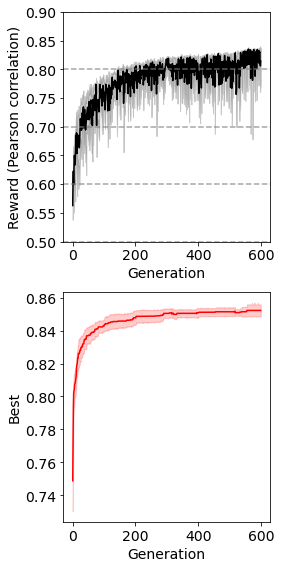

In [5]:
%matplotlib inline
fig, axs = plt.subplots(2,1, figsize=(4,8))
make_plot(pd.concat([kinn_df1, kinn_df2]), ax=axs[1], ax2=axs[0])
fig.tight_layout()

## Fig. 3B

Summarizes multiple runs of AMBER-CNN, visualizing the difference between KINN and CNN

CNN = KINN + delta

In [6]:
cnn_1 = read_cnn_train_hist([
    "/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn/tarball_0.0.1/outputs/CNN-wtCas9_cleave_rate_log-sgRNA1/train_history.csv",
])
cnn_2 = read_cnn_train_hist([
    "/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn/tarball_0.0.1/outputs/CNN-wtCas9_cleave_rate_log-sgRNA2/train_history.csv"    
])

In [7]:
a = cnn_1 - kinn_df1
a['Generation'] = cnn_1['Generation']
b = cnn_2 - kinn_df2
b['Generation'] = cnn_2['Generation']

kinn_minus_cnn = pd.concat([a,b])

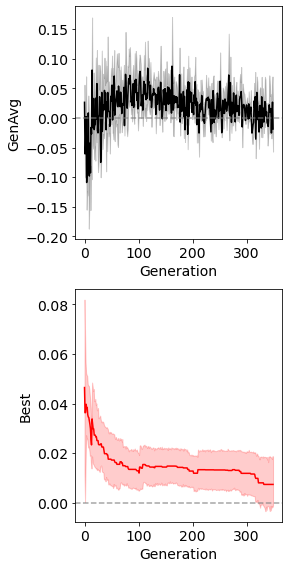

In [8]:
fig, axs = plt.subplots(2,1, figsize=(4,8))
ax = sns.lineplot(x='Generation', y='Best', data=kinn_minus_cnn, ax=axs[1], color="red", label="BestIndv")
ax.axhline(y=0, ls="--", color="grey", alpha=0.7)
ax.legend().remove()
ax = sns.lineplot(x='Generation', y='GenAvg', data=kinn_minus_cnn, ax=axs[0], color="black", label="Generation Avg.")
ax.axhline(y=0, ls="--", color="grey", alpha=0.7)
ax.legend().remove()

fig.tight_layout()

## Fig. 3C

Compare the trainable parameters

In [9]:
# trainEnv parameters
evo_params = dict(
    model_fn = src.KineticNeuralNetworkBuilder,
)

# manager configs
manager_kwargs={
    'output_op': lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(x)/np.log(10), name="output_log"),  # change the clip as well
    'n_feats': 25,  # remember to change this!!
    'n_channels': 9,
    'verbose': 0
}

In [10]:
sess = tf.Session()
kinn_paths = [
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep1-gRNA1/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep2-gRNA1/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA1/",    
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep1-gRNA2/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep2-gRNA2/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA2/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA2/",
    "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/",
]

model_ids = ['_'.join(x.split('/')[-2].split('-')[-4:]) for x in kinn_paths]

kinns = []
for p in kinn_paths:
    kinns.append(
        reload_from_dir(
            wd=p,
            sess=sess,
            manager_kwargs=manager_kwargs,
            model_fn=evo_params['model_fn']
        )
    )


In [11]:
param_cnt = {}
for mid, kinn in zip(*[model_ids, kinns]):
    trainable_cnt = int(np.sum([tf.keras.backend.count_params(p) for p in set(kinn.model.trainable_weights)]))
    param_cnt[mid] = {'model_type': 'kinn', 'params': trainable_cnt}

In [12]:
# load cnn
wd = "outputs/CNN-wtCas9_cleave_rate_log-0/"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn_1 = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

wd = "outputs/CNN-wtCas9_cleave_rate_log-1/"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn_2 = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

In [13]:
param_cnt['CNN_gRNA1'] = {
    'model_type': 'cnn', 
    'params': int(np.sum([tf.keras.backend.count_params(p) for p in set(dcnn_1.trainable_weights)]))
}
param_cnt['CNN_gRNA2'] = {
    'model_type': 'cnn',
    'params': int(np.sum([tf.keras.backend.count_params(p) for p in set(dcnn_2.trainable_weights)]))
}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


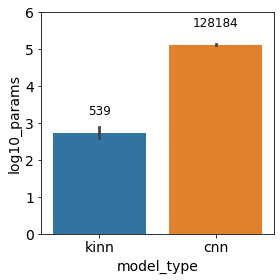

In [14]:
param_cnt_df = pd.DataFrame(param_cnt).transpose()
param_cnt_df['log10_params'] = [np.log10(x) for x in param_cnt_df['params']]

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.barplot(x='model_type', y='log10_params', data=param_cnt_df, ci='sd', ax=ax)
offset = 0.6
kinn_mean = param_cnt_df.query('model_type=="kinn"')['log10_params'].mean()
cnn_mean = param_cnt_df.query('model_type=="cnn"')['log10_params'].mean()

ax.text(0, kinn_mean + offset, "%i"%10**kinn_mean, ha='center', va='center', fontsize=12)
ax.text(1, cnn_mean + offset, "%i"%10**cnn_mean, ha='center', va='center', fontsize=12)
ax.set_ylim(0,6)
fig.tight_layout()

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w


Last updated: Wed Sep 07 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

src       : 0.0.1
seaborn   : 0.11.1
amber     : 0.1.2-pmbga
matplotlib: 3.4.3
numpy     : 1.21.6
pandas    : 1.3.5
tensorflow: 1.15.0

Watermark: 2.3.1

